<a href="https://colab.research.google.com/github/smromel43/diabetic-retinopathy-research/blob/main/retina_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import MobileNetV2, DenseNet169, InceptionV3
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'numpy'

In [ ]:
data_dir = '/content/drive/MyDrive/Retina/archive'
keyword=['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']
class_folders = os.listdir(data_dir)
image_paths = []
labels = []

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
            class_path = os.path.join(data_dir, class_folder)
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(class_folder)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [ ]:
print("The classes:\n", np.unique(df['label']))

The classes:
 ['Healthy' 'Mild DR' 'Moderate DR' 'Proliferate DR' 'Severe DR']


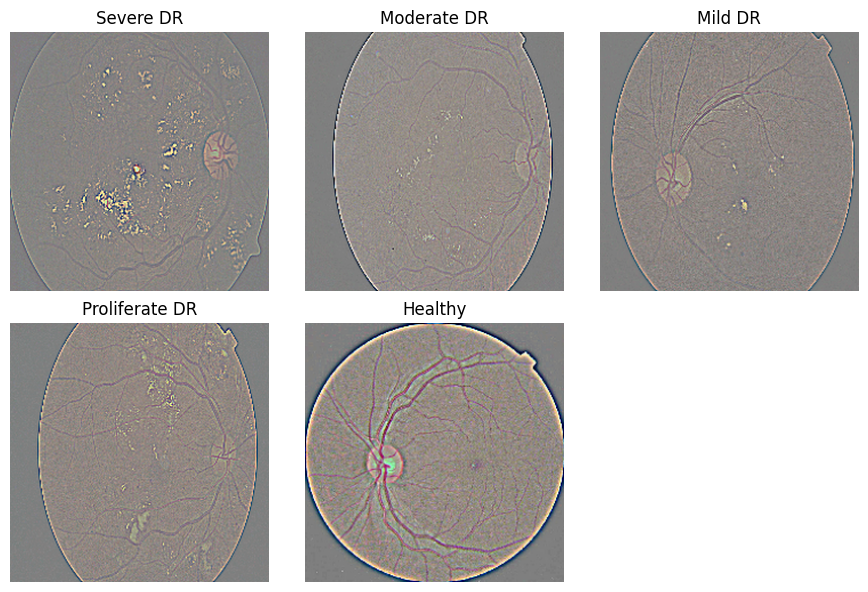

In [ ]:
num_classes = len(df['label'].unique())

num_images_per_row = 3
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(9, 3 * num_rows))

for i, new_class in enumerate(df['label'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    path = os.path.join(data_dir, df[df['label'] == new_class]['image_path'].iloc[0])

    if os.path.exists(path):
        sample_image = cv2.imread(path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(new_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {path}")
    else:
        print(f"Error: Image path does not exist: {path}")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [ ]:
def load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224)):

    train_datagen = ImageDataGenerator(
       rescale=1./255,
        rotation_range=30,  # Increase rotation range
        width_shift_range=0.3,  # Increase width shift range
        height_shift_range=0.3,  # Increase height shift range
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=32,
        class_mode='categorical'
       # shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = load_images_for_cnn(train_df, val_df, test_df, batch_size=32, target_size=(224, 224))

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


## MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
input_tensor = Input(shape=(224, 224, 3))
MobileNet_base = MobileNet(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)

MobileNet_base.trainable = False
x = Flatten()(MobileNet_base.output)
x = Dropout(0.8)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units= 5, activation='softmax')(x)  # Adjust units according to your output classes

model_mobilenet = Model(inputs=MobileNet_base.input, outputs=output)
model_mobilenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#model_mobilenet.summary()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
epochs = 50
history_mobilenet = model_mobilenet.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/50
69/69 [==============================] - 700s 10s/step - loss: 6.2122 - accuracy: 0.4964 - val_loss: 0.8272 - val_accuracy: 0.7055
Epoch 2/50
69/69 [==============================] - 41s 583ms/step - loss: 1.0452 - accuracy: 0.6123 - val_loss: 0.8332 - val_accuracy: 0.7018
Epoch 3/50
69/69 [==============================] - 41s 593ms/step - loss: 0.9527 - accuracy: 0.6286 - val_loss: 0.8098 - val_accuracy: 0.7273
Epoch 4/50
69/69 [==============================] - 43s 624ms/step - loss: 0.9594 - accuracy: 0.6405 - val_loss: 0.7960 - val_accuracy: 0.6691
Epoch 5/50
69/69 [==============================] - 42s 614ms/step - loss: 0.9421 - accuracy: 0.6427 - val_loss: 0.8279 - val_accuracy: 0.6691
Epoch 6/50
69/69 [==============================] - 43s 628ms/step - loss: 0.9313 - accuracy: 0.6450 - val_loss: 0.8040 - val_accuracy: 0.6945
Epoch 7/50
69/69 [==============================] - 44s 640ms/step - loss: 0.9415 - accuracy: 0.6450 - val_loss: 0.8165 - val_accuracy: 0.7164


In [ ]:
test_loss, test_accuracy = model_mobilenet.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

9/9 [==============================] - 64s 8s/step - loss: 0.8172 - accuracy: 0.6691
Test Loss: 0.8171951174736023, Test Accuracy: 0.6690909266471863


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_mobilenet.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

9/9 [==============================] - 2s 175ms/step
                precision    recall  f1-score   support

       Healthy       0.39      0.40      0.40        89
       Mild DR       0.14      0.20      0.16        40
   Moderate DR       0.36      0.44      0.39        98
Proliferate DR       0.33      0.03      0.05        34
     Severe DR       0.00      0.00      0.00        14

      accuracy                           0.32       275
     macro avg       0.24      0.21      0.20       275
  weighted avg       0.32      0.32      0.30       275



<Axes: >

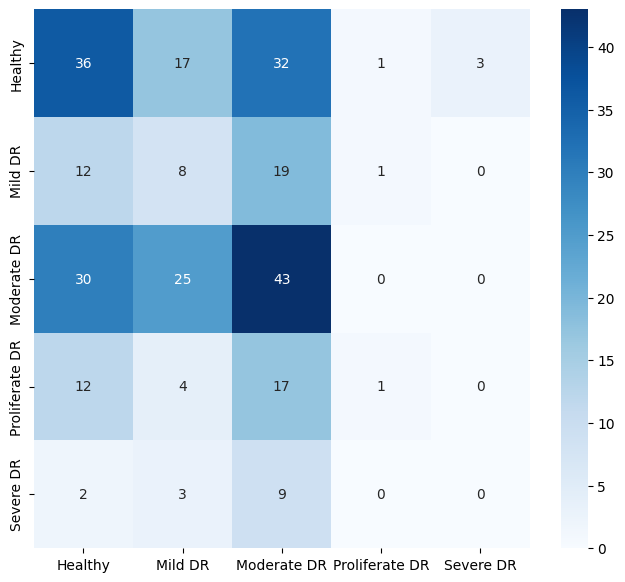

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']],
                  columns = [i for i in  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='d')

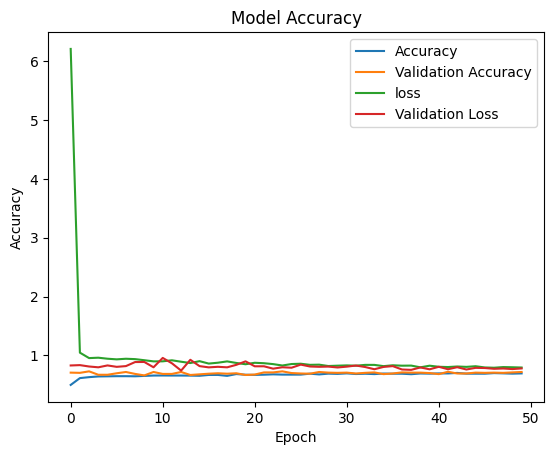

In [ ]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(history_mobilenet.history['accuracy'])
plt.plot(history_mobilenet.history['val_accuracy'])
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
input_tensor = Input(shape=(224, 224, 3))
DenseNet_base = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)
DenseNet_base.trainable = False
x = Flatten()(DenseNet_base.output)
x = Dropout(0.8)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units= 5, activation='softmax')(x)
model_densenet = Model(inputs=DenseNet_base.input, outputs=output)

model_densenet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_densenet.summary()
epochs = 50
history_densenet = model_densenet.fit(train_generator, epochs=epochs, validation_data=validation_generator)
test_loss, test_accuracy = model_densenet.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_densenet.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']],
                  columns = [i for i in  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='d')

In [ ]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(history_densenet.history['accuracy'])
plt.plot(history_densenet.history['val_accuracy'])
plt.plot(history_densenet.history['loss'])
plt.plot(history_densenet.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
input_tensor = Input(shape=(224, 224, 3))
VGG16_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)
VGG16_base.trainable = False
x = Flatten()(VGG16_base.output)
x = Dropout(0.8)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units= 5, activation='softmax')(x)
model_vgg16 = Model(inputs=VGG16_base.input, outputs=output)


model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg16.summary()
epochs = 50
history_vgg16 = model_vgg16.fit(train_generator, epochs=epochs, validation_data=validation_generator)
test_loss, test_accuracy = model_vgg16.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_vgg16.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

9/9 [==============================] - 3s 273ms/step
                precision    recall  f1-score   support

       Healthy       0.31      0.38      0.35        89
       Mild DR       0.08      0.15      0.11        40
   Moderate DR       0.31      0.27      0.28        98
Proliferate DR       0.00      0.00      0.00        34
     Severe DR       0.10      0.07      0.08        14

      accuracy                           0.24       275
     macro avg       0.16      0.17      0.16       275
  weighted avg       0.23      0.24      0.23       275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

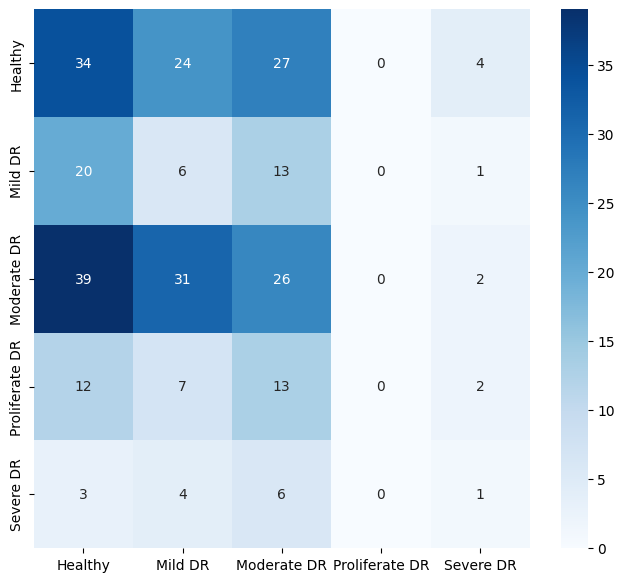

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']],
                  columns = [i for i in  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='d')

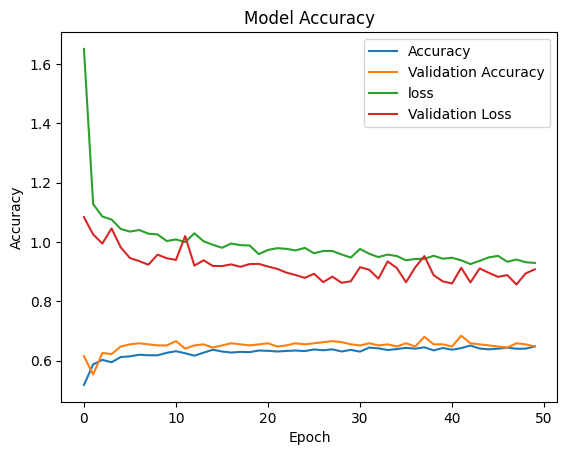

In [ ]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
import tensorflow as tf
input_tensor = Input(shape=(224, 224, 3))
VGG19_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)
VGG19_base.trainable = False
x = Flatten()(VGG19_base.output)
x = Dropout(0.8)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units= 5, activation='softmax')(x)  # Adjust units according to your output classes
model_vgg19 = Model(inputs=VGG19_base.input, outputs=output)

model_vgg19.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_vgg19.summary()
epochs = 50
history_vgg19 = model_vgg19.fit(train_generator, epochs=epochs, validation_data=validation_generator)
test_loss, test_accuracy = model_vgg19.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_vgg19.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

9/9 [==============================] - 2s 196ms/step
                precision    recall  f1-score   support

       Healthy       0.32      0.39      0.35        89
       Mild DR       0.12      0.03      0.04        40
   Moderate DR       0.37      0.58      0.45        98
Proliferate DR       0.00      0.00      0.00        34
     Severe DR       0.00      0.00      0.00        14

      accuracy                           0.34       275
     macro avg       0.16      0.20      0.17       275
  weighted avg       0.25      0.34      0.28       275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

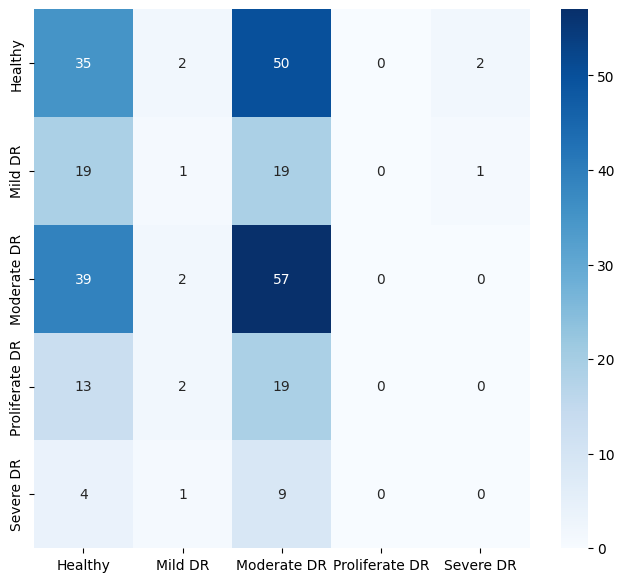

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']],
                  columns = [i for i in  ['Healthy','Mild DR', 'Moderate DR','Proliferate DR','Severe DR']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='d')

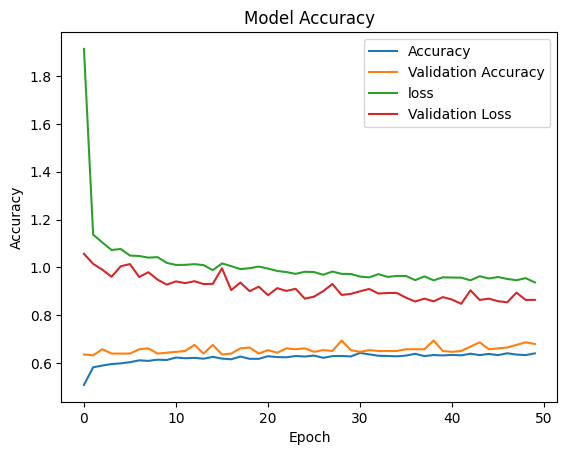

In [ ]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(history_vgg19.history['accuracy'])
plt.plot(history_vgg19.history['val_accuracy'])
plt.plot(history_vgg19.history['loss'])
plt.plot(history_vgg19.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.models import Model
input_tensor = Input(shape=(224, 224, 3))
InceptionV3_base = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)
InceptionV3_base.trainable = False
x = Flatten()(InceptionV3_base.output)
x = Dropout(0.8)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
output = Dense(units= 5, activation='softmax')(x)  # Adjust units according to your output classes
model_inceptionv3 = Model(inputs=InceptionV3_base.input, outputs=output)

model_inceptionv3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_inceptionv3.summary()
epochs = 50
history_inceptionv3 = model_inceptionv3.fit(train_generator, epochs=epochs, validation_data=validation_generator)
test_loss, test_accuracy = model_inceptionv3.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = model_inceptionv3.predict(test_generator)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test_generator.classes
class_labels =  ['Mild','Moderate', 'No_DR','Proliferate_DR','Severe']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

9/9 [==============================] - 3s 179ms/step
                precision    recall  f1-score   support

          Mild       0.36      0.36      0.36        89
      Moderate       0.06      0.05      0.06        40
         No_DR       0.36      0.54      0.43        98
Proliferate_DR       0.67      0.06      0.11        34
        Severe       0.00      0.00      0.00        14

      accuracy                           0.32       275
     macro avg       0.29      0.20      0.19       275
  weighted avg       0.33      0.32      0.29       275



<Axes: >

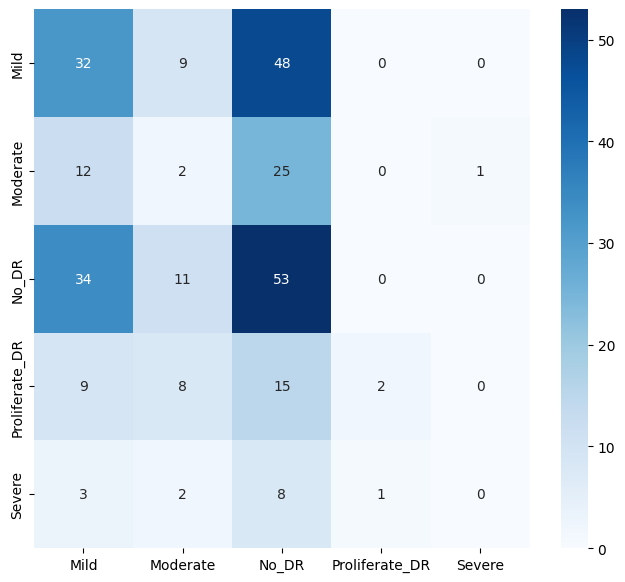

In [ ]:
import seaborn as sn
cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Mild','Moderate', 'No_DR','Proliferate_DR','Severe']],
                  columns = [i for i in  ['Mild','Moderate', 'No_DR','Proliferate_DR','Severe']])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='d')

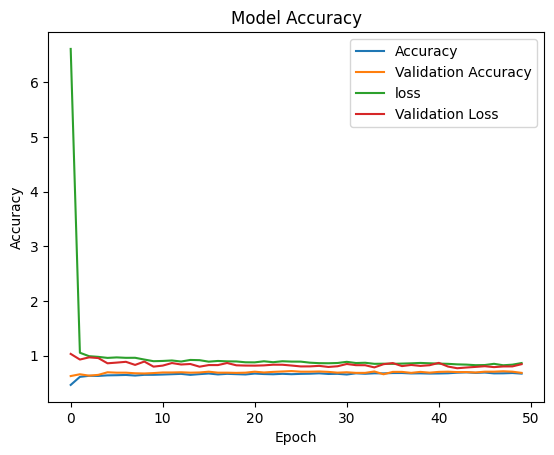

In [ ]:
#Ploting Acuracy & Loss
import matplotlib.pyplot as plt
plt.plot(history_inceptionv3.history['accuracy'])
plt.plot(history_inceptionv3.history['val_accuracy'])
plt.plot(history_inceptionv3.history['loss'])
plt.plot(history_inceptionv3.history['val_loss'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()